## Сигнал B1I

# Подключаем библиотеки

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy import signal

# Определяем переменные сигнала

In [45]:
# Параметры ПСП
fcode =  int(2.046e6) #int(10.230e6)
code_length = 2046 #10230
chip_rate = code_length * 1000

# Параметры модели сигнала
fcode2fcarr = 1
fcarr2fs = 10
carrier_freq = fcode * fcode2fcarr  # Частота ПЧ Beidou B1I
fs = carrier_freq * fcarr2fs        # Частота дискретизации
n_resample = fcode2fcarr * fcarr2fs # количество отсчетов на один чип ПСП(ресемплинг).

T_prn = 1e-3                                            # период ПСП, сек
noPrn = 40                                              # количество ПСП
noSat = 9                                               # номер спутника
T_overlay = 20e-3                                       # период оверлейного кода
n_noPrn_vs_T_overlay = int(noPrn / (T_overlay * 1e3))   # сколько периодов ОК помещается в весь сигнал 


# Создание ПСП для сигнала b1i

In [46]:
b1i_g2_taps = {
   1: (1,3),    2: (1,4),    3: (1,5),    4: (1,6),
   5: (1,8),    6: (1,9),    7: (1,10),   8: (1,11),
   9: (2,7),   10: (3,4),   11: (3,5),   12: (3,6),
  13: (3,8),   14: (3,9),   15: (3,10),  16: (3,11),
  17: (4,5),   18: (4,6),   19: (4,8),   20: (4,9),
  21: (4,10),  22: (4,11),  23: (5,6),   24: (5,8),
  25: (5,9),   26: (5,10),  27: (5,11),  28: (6,8),
  29: (6,9),   30: (6,10),  31: (6,11),  32: (8,9),
  33: (8,10),  34: (8,11),  35: (9,10),  36: (9,11),
  37: (10,11),
  38: (1,2,7),  39: (1,3,4),  40: (1,3,6),  41: (1,3,8),
  42: (1,3,10), 43: (1,3,11), 44: (1,4,5),  45: (1,4,9),
  46: (1,5,6),  47: (1,5,8),  48: (1,5,10), 49: (1,5,11),
  50: (1,6,9),  51: (1,8,9),  52: (1,9,10), 53: (1,9,11),
  54: (2,3,7),  55: (2,5,7),  56: (2,7,9),  57: (3,4,5),
  58: (3,4,9),  59: (3,5,6),  60: (3,5,8),  61: (3,5,10),
  62: (3,5,11), 63: (3,6,9)
} # Каждому спутнику присваивается свой PRN-номер (в данном случае от 1 до 63). Это позволяет наземным приемникам отличать сигналы разных спутников.
# Каждому PRN (ключу словаря) соответствует реализация из 2 или 3 номеров отводов.
# Для 2 отводов: код генерируется как G1[10] ^ G2[tap1] ^ G2[tap2]
# Допустим, для PRN=1 заданы отводы (1, 3): Берутся биты из позиций 1 и 3 регистра G2.
# Вычисляется XOR: G1[10] ^ G2[1] ^ G2[3]
# Результат становится новым битом кода B1I.

def b1i_g1_shift(x):
  return [x[0]^x[6]^x[7]^x[8]^x[9]^x[10]] + x[0:10] # Вычисление нового бита: XOR элементов 0, 6, 7, 8, 9, 10

def b1i_g2_shift(x):
  return [x[0]^x[1]^x[2]^x[3]^x[4]^x[7]^x[8]^x[10]] + x[0:10] # Вычисление нового бита: XOR элементов 0, 6, 7, 8, 9, 10

def b1i(prn):
  n = code_length
  nt = len(b1i_g2_taps[prn]) # Количество отводов (2 или 3)
  if nt==2:
    (tap1,tap2) = b1i_g2_taps[prn]
  else:
    (tap1,tap2,tap3) = b1i_g2_taps[prn]
  # Инициализация регистров G1 и G2 начальными значениями
  g1 = [0,1,0,1,0,1,0,1,0,1,0] # Регистр G1
  g2 = [0,1,0,1,0,1,0,1,0,1,0] # Регистр G2
  b1i = np.zeros(n) # Массив для хранения сгенерированного кода
  for i in range(n):
     # Вычисление текущего бита кода:
    if nt==2:
      b1i[i] = g1[10] ^ g2[tap1-1] ^ g2[tap2-1]
    else:
      b1i[i] = g1[10] ^ g2[tap1-1] ^ g2[tap2-1] ^ g2[tap3-1]
     # Сдвиг регистров
    g1 = b1i_g1_shift(g1)
    g2 = b1i_g2_shift(g2)
  return 1.0 - 2.0*b1i  # Преобразуем {0,1} в {-1,1}

# Кэш для хранения сгенерированных кодов (чтобы не вычислять повторно)
codes = {}

# Функция для получения кода B1I по номеру PRN
def b1i_code(prn):
  if prn not in codes:
    codes[prn] = b1i(prn)
  return codes[prn]

# Формируем несущую, ПСП с ресемплингом, сигнал

In [47]:
prn_resampled = np.repeat(b1i_code(noSat), n_resample) #ресемплинг(на каждый чип по n_resample отсчетов)
prn_resampled_noprn = np.array(list(prn_resampled)*noPrn)

t = np.arange(0, T_prn*noPrn, 1/fs)  # Временная ось (для нашего ПСП 1 мс)

# Генерация синусоиды
phase = 0  # Начальная фаза (0 или π/2 для когерентной модуляции)
carrier = np.sin(2 * np.pi * carrier_freq * t + phase)

# Формирование B1I-сигнала (модуляция)
b1i_signal =   prn_resampled_noprn * carrier

# Графики ПСП для разных НКА до ресемплинга

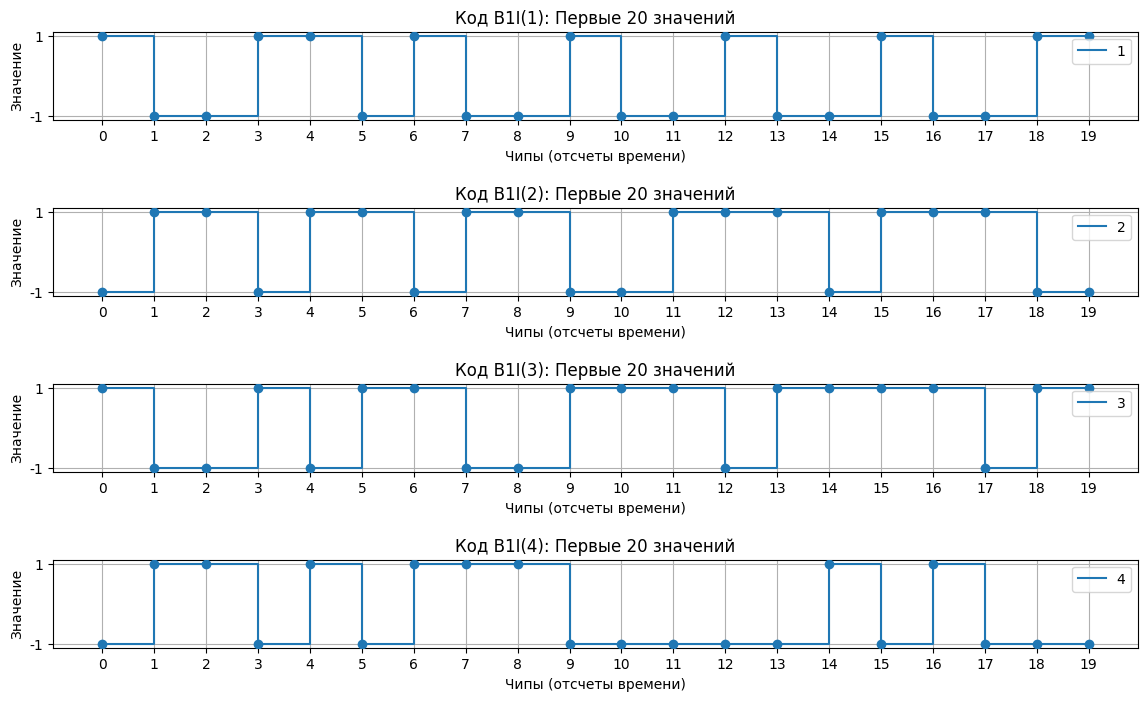

In [48]:
# Создание графиков

prn_codes = {1: b1i_code(1), 2: b1i_code(2), 3: b1i_code(3), 4: b1i_code(4)}

plt.figure(figsize=(14, 8))
for i, (label, prn) in enumerate(prn_codes.items(), 1):
    plt.subplot(4, 1, i)
    time_steps = np.arange(20)  # Отсчеты времени
    plt.scatter(time_steps, prn[:20], zorder=3)  # Точки
    plt.step(time_steps, prn[:20], where='post', label=label)

    plt.title("Код B1I("f"{label}): Первые 20 значений")
    plt.xlabel("Чипы (отсчеты времени)")
    plt.ylabel("Значение")
    plt.xticks(time_steps)  # Показываем все отсчеты на оси X
    plt.yticks([-1, 1], labels=["-1", "1"])
    plt.grid()
    plt.legend()

plt.subplots_adjust(hspace=1)
plt.show()

# Проверка АКФ, ВКФ для ПСП до ресемплинга

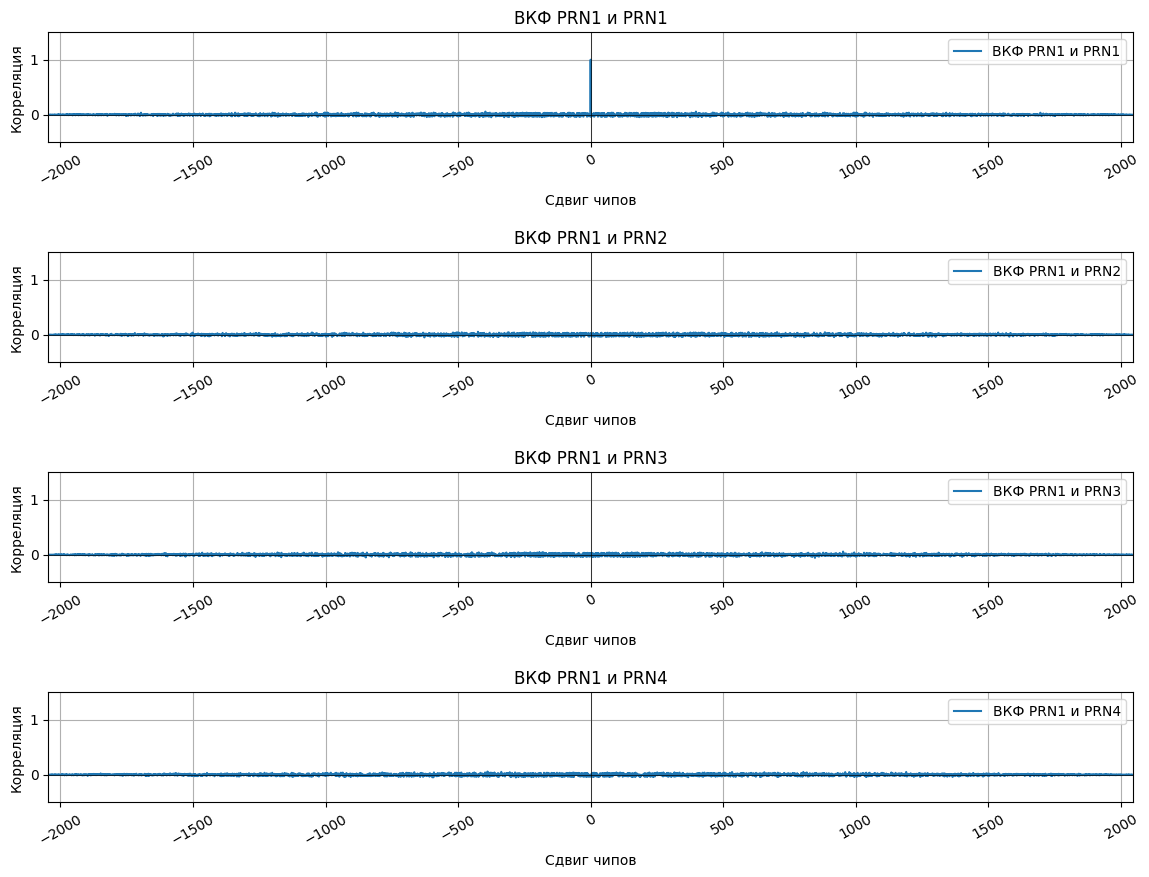

In [49]:
# Функция для вычисления взаимнокорреляции
def cross_correlation(x, y):
    n = len(x)
    shifts = np.arange(-n + 1, n) # сдвиг для вычисления кореляции
    correlation = signal.correlate(x, y, mode='full') / n
    return shifts, correlation

# Построение графикоф ВКФ
plt.figure(figsize=(14, 10))  # Увеличенный размер фигуры

xlim_range = (-code_length, code_length) # Устанавливаем диапазон по X
ylim_range = (-0.5, 1.5)   # Устанавливаем диапазон по Y

# Построение графиков ВКФ
for i, prn_num in enumerate(prn_codes.keys(), 1):
    shifts, correlation = cross_correlation(b1i_code(1), prn_codes[prn_num])

    plt.subplot(4, 1, i)
    plt.plot(shifts, correlation, label=f'ВКФ PRN1 и PRN{prn_num}')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('Сдвиг чипов', fontsize=10)  # Уменьшаем шрифт подписей
    plt.ylabel('Корреляция', fontsize=10)
    plt.xticks(rotation=30)  # Поворачиваем подписи на оси X, если нужно
    plt.title(f'ВКФ PRN1 и PRN{prn_num}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid()

    # Устанавливаем одинаковые масштабы
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)

    plt.subplots_adjust(hspace=1)

# Графики ПСП после ресемплинга

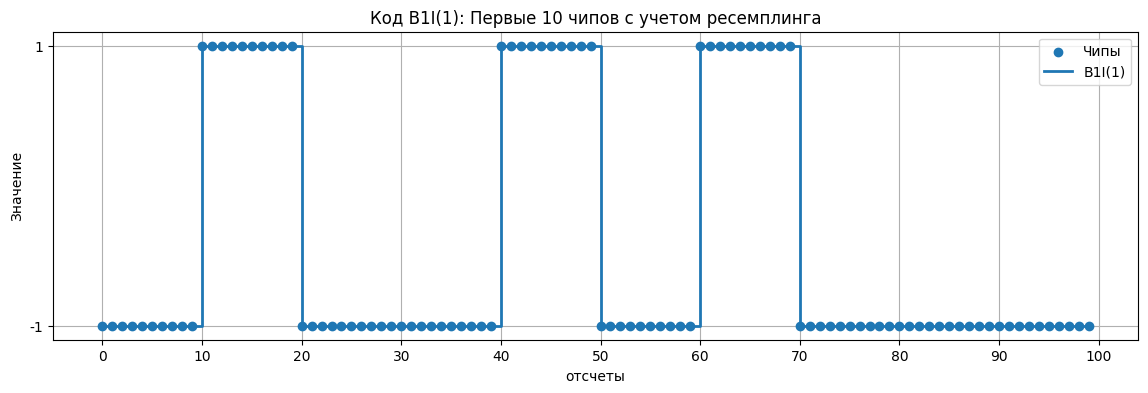

In [50]:
# Создание графиков
time_steps = np.arange(n_resample*10) # time_steps будет содержать значения от 0 до (n_resample * 10 - 1).

# Создание графика
plt.figure(figsize=(14, 4))
plt.scatter(time_steps, prn_resampled_noprn[:(n_resample*10)], zorder=3, label="Чипы")  # Точки
plt.step(time_steps, prn_resampled_noprn[:(n_resample*10)], where='post', label="B1I(1)", linewidth=2)  # Лестничная диаграмма

# Настройки графика
plt.title("Код B1I(1): Первые 10 чипов с учетом ресемплинга")
plt.xlabel("отсчеты")
plt.ylabel("Значение")
plt.xticks(np.arange(0, 11*n_resample, n_resample))  # Метки с шагом n_resample: 0, n_resample, 2*n_resample, ... 10*n_resample
plt.yticks([-1, 1], labels=["-1", "1"])
plt.grid()
plt.legend()

# Показ графика
plt.show()

# Построение АКФ для ПСП после ресемплинга

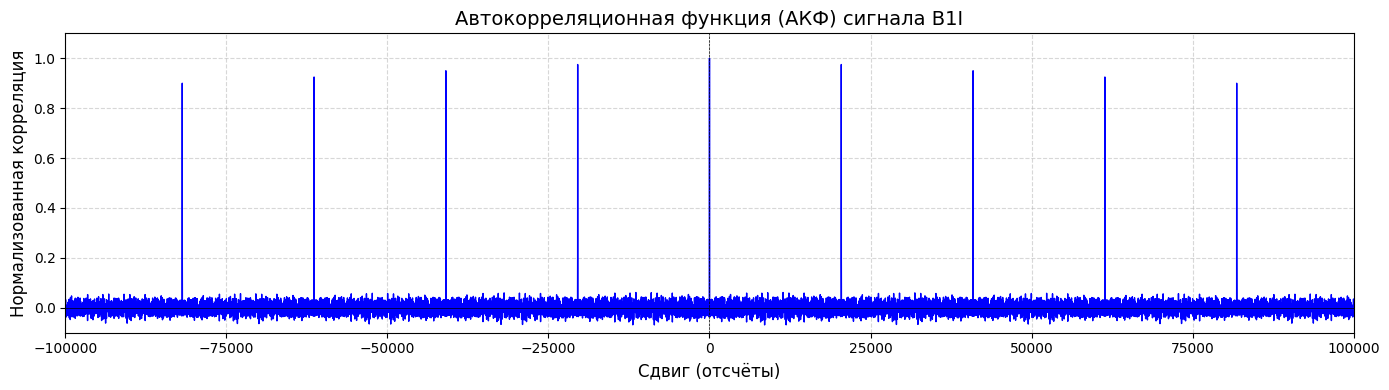

In [57]:
def funcFFT(__input_signal, noSamPerSym):
    # Вычисление нормированного БПФ (FFT) сигнала
    
    # Вычисление прямого БПФ
    yf = fft(__input_signal)
    
    # Нахождение максимального значения амплитуды
    maxVal = max(np.abs(yf))
    
    # Нормировка результатов БПФ на максимальное значение
    yf = yf / maxVal
    
    # Вычисление частотной оси для БПФ
    # chip_rate*noSamPerSym - частота дискретизации сигнала
    xf = fftfreq(len(yf), 1 / (chip_rate*noSamPerSym))
    
    # Возвращает:
    # xf - массив частот (в Гц)
    # yf - нормированные комплексные значения БПФ
    return [xf, yf]

shifts, acf = cross_correlation(prn_resampled_noprn, prn_resampled_noprn)

# Визуализация АКФ в отсчётах
plt.figure(figsize=(14, 4))
plt.plot(shifts, acf/np.max(acf) , linewidth=1, color='blue')

# Увеличиваем диапазон до ±1000*n_resample отсчётов
max_shift = 10000*n_resample  # Показываем ±1000*n_resample отсчётов
plt.xlim(-max_shift, max_shift)
#plt.xlim(-1000, 1000)
plt.ylim(-0.1, 1.1)

# Подписи осей и заголовок
plt.xlabel("Сдвиг (отсчёты)", fontsize=12)
plt.ylabel("Нормализованная корреляция", fontsize=12)
plt.title("Автокорреляционная функция (АКФ) сигнала B1I", fontsize=14)

# Линии сетки и вспомогательные элементы
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# График сигнала во временной области

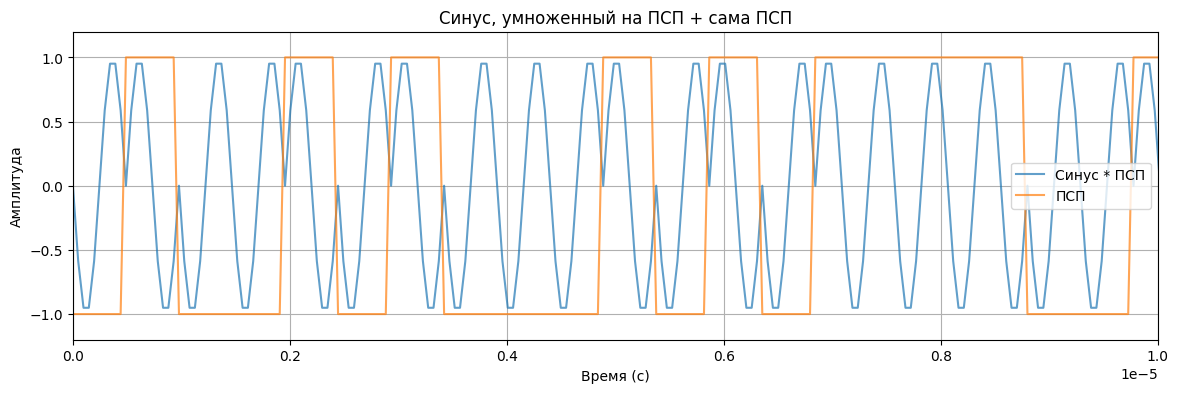

In [53]:
plt.figure(figsize=(14, 4))

# График "Синус * ПСП"
plt.plot(t, b1i_signal, label="Синус * ПСП", alpha=0.7)

# График самой ПСП (добавляем пунктирной линией)
plt.plot(t, prn_resampled_noprn, label="ПСП", alpha=0.7)

# Настройки графика
plt.xlim(0, 10e-6)  # Можно менять, чтобы смотреть разные масштабы
plt.ylim(-1.2, 1.2) # Чтобы сигнал и ПСП были видны
plt.title('Синус, умноженный на ПСП + сама ПСП')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid()
plt.show()

# Построение СПМ от АКФ ПСП после ресемплинга

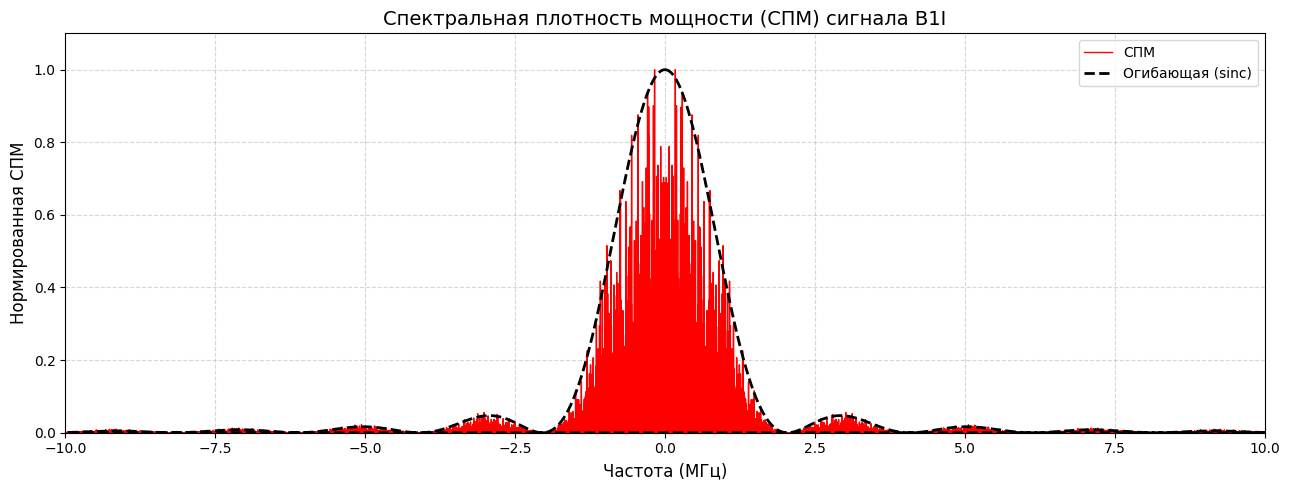

In [58]:
# Вычисляем СПМ через БПФ АКФ
freqs, spd = funcFFT(list(acf), n_resample)
freqs_MHz = freqs / 1e6

# Теоретическая огибающая sinc
spd_teoretic = np.power(np.sinc(freqs/fcode),2) # Энергия прямоугольного импульса

# Визуализация СПМ и огибающей
plt.figure(figsize=(13, 5))
plt.plot(freqs_MHz, np.abs(spd), linewidth=1, color='red', label='СПМ')
plt.plot(freqs_MHz, np.abs(spd_teoretic), '--', linewidth=2, color='black', label='Огибающая (sinc)')

# Настройки графика
plt.xlabel("Частота (МГц)", fontsize=12)
plt.ylabel("Нормированная СПМ", fontsize=12)
plt.title("Спектральная плотность мощности (СПМ) сигнала B1I", fontsize=14)
plt.xlim(-10, 10)
plt.ylim(0, 1.1)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Формируем оверлейный код

In [55]:
# Определяем NH-код только для спутников 6-58
if 6 <= noSat <= 58:
    # Исходный NH-код (0 и 1) - 20 бит = 1 период (20 мс)
    nh_code_01 = np.array([0,0,0,0,0,1,1,1,0,1,0,1,0,0,1,1,0,0,1,0])
    # Для 40 периодов ПСП (40 мс) используем 2 периода NH-кода
    nh_code_01 = np.tile(nh_code_01, n_noPrn_vs_T_overlay)  # Теперь 40 бит (np.tile(a, reps) - повторяет весь массив указанное количество раз)
    
    print("Проверка NH-кода (первые 15 бит):", nh_code_01[:15])
    
    # Преобразуем в -1 и 1
    nh_code = 2 * nh_code_01 - 1
    #nh_code = nh_code_01 # оставим 0 и 1 для проверки
    
    # Создаем NH-сигнал (повторяем каждый бит нужное количество раз)
    samples_per_chip = int(T_prn * fs)  # Отсчётов на 1 чип ПСП
    nh_signal = np.repeat(nh_code, samples_per_chip)
else:
    # Для остальных спутников создаем единичный сигнал (все +1)
    nh_signal = np.ones(noPrn * int(T_prn * fs))  # 40 мс
    print(f"NH-код не используется для спутника {noSat}")

# Проверка соответствия длин
assert len(nh_signal) == len(b1i_signal), "Ошибка: длины сигналов не совпадают!"
print(f"Длина NH-сигнала: {len(nh_signal)} отсчётов (40 мс)")

Проверка NH-кода (первые 15 бит): [0 0 0 0 0 1 1 1 0 1 0 1 0 0 1]
Длина NH-сигнала: 818400 отсчётов (40 мс)


C:\Users\Peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


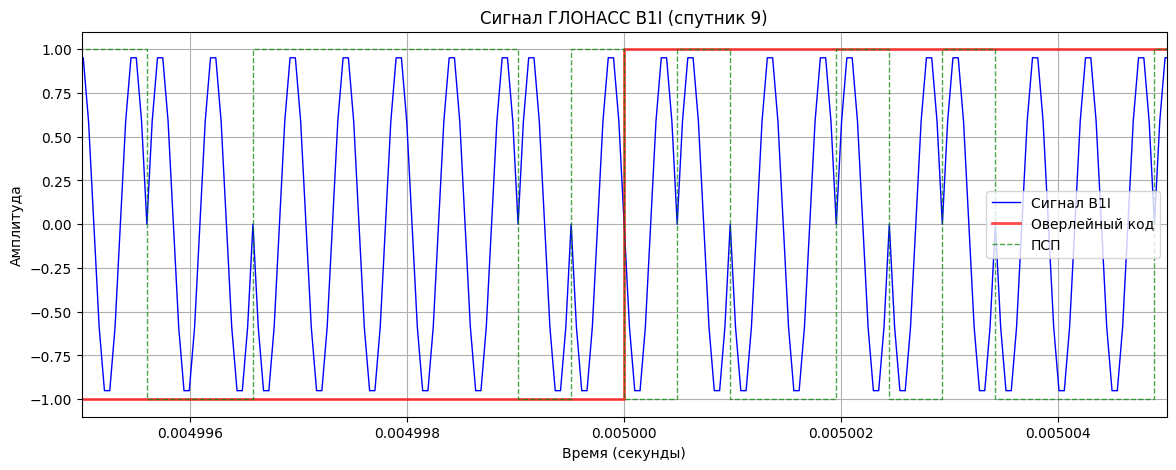

In [63]:
b1i_signal_noPrn = b1i_signal * nh_signal
t = np.arange(0, T_prn*noPrn, 1/fs)

plt.figure(figsize=(14, 5))

# 1. Основной сигнал B1I (гладкий)
plt.plot(t, b1i_signal_noPrn, 
         label="Сигнал B1I", 
         color='blue',
         linewidth=1)

# 2. Оверлейный код (ступенчатый)
plt.step(t, nh_signal, 
         where='post',  # Переходы после точек данных
         linestyle='-', 
         color='red',
         label="Оверлейный код",
         linewidth=2,
         alpha=0.7)

#3. 
plt.step(t, prn_resampled_noprn, 
         where='post',  # Переходы после точек данных
         linestyle='--', 
         color='green',
         label="ПСП",
         linewidth=1,
         alpha=0.7)

# Настройки осей
plt.xlim(5e-3 - 5e-6, 5e-3 + 5e-6)  # 40 мс
plt.ylim(-1.1, 1.1)
plt.grid(True)

# Подписи
plt.title(f'Сигнал ГЛОНАСС B1I (спутник {noSat})')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.legend()

plt.show()
# смотрю здесь, так как тут переход ОК от -1 в 1